<a href="https://colab.research.google.com/github/aricahyasaputra/machine-learning-course-assigment/blob/main/Minggu%2013%20RRN/Tugas_Minggu_13_RNN_concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==0.17.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install matplotlib==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Concise Implementation of Recurrent Neural Networks
:label:`sec_rnn-concise`

While :numref:`sec_rnn_scratch` was instructive to see how RNNs are implemented,
this is not convenient or fast.
This section will show how to implement the same language model more efficiently
using functions provided by high-level APIs
of a deep learning framework.
We begin as before by reading the time machine dataset.


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**Defining the Model**]

High-level APIs provide implementations of recurrent neural networks.
We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and 256 hidden units.
In fact, we have not even discussed yet what it means to have multiple layers---this will happen in :numref:`sec_deep_rnn`.
For now, suffice it to say that multiple layers simply amount to the output of one layer of RNN being used as the input for the next layer of RNN.


In [ ]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True,
    return_sequences=True, return_state=True)

In [ ]:
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

[**With a hidden state and an input,
we can compute the output with
the updated hidden state.**]
It should be emphasized that
the "output" (`Y`) of `rnn_layer`
does *not* involve computation of output layers:
it refers to
the hidden state at *each* time step,
and they can be used as the input
to the subsequent output layer.


In [ ]:
X = tf.random.uniform((num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 32, 256]), 32, TensorShape([256]))

Similar to :numref:`sec_rnn_scratch`,
[**we define an `RNNModel` class
for a complete RNN model.**]
Note that `rnn_layer` only contains the hidden recurrent layers, we need to create a separate output layer.


In [ ]:
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        # Later RNN like `tf.keras.layers.LSTMCell` return more than two values
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

## Training and Predicting

Before training the model, let us [**make a prediction with the a model that has random weights.**]


In [ ]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

d2l.predict_ch8('time traveller', 10, net, vocab)

'time travellermjxn pn<unk>ag'

As is quite obvious, this model does not work at all. Next, we call `train_ch8` with the same hyperparameters defined in :numref:`sec_rnn_scratch` and [**train our model with high-level APIs**].


perplexity 1.3, 19456.1 tokens/sec on /GPU:0
time traveller but now you begin to seet ion anomather thea tron
traveller for st is plingry of the flesh which is a ainee s


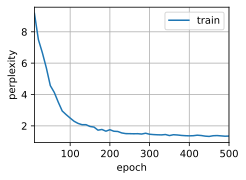

In [ ]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)

Compared with the last section, this model achieves comparable perplexity,
albeit within a shorter period of time, due to the code being more optimized by
high-level APIs of the deep learning framework.


## Summary

* High-level APIs of the deep learning framework provides an implementation of the RNN layer.
* The RNN layer of high-level APIs returns an output and an updated hidden state, where the output does not involve output layer computation.
* Using high-level APIs leads to faster RNN training than using its implementation from scratch.


Reference : https://d2l.ai/chapter_recurrent-neural-networks/rnn-concise.html